In [30]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.ticker as mtick

In [31]:
# Load dataset
df = pd.read_csv("Walmart_Store_sales.csv")

# Overview

In [32]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [33]:
df.shape

(150, 8)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [35]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [36]:
df.isna().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

# Exploratory Data Analysis

In [37]:
# Parse dates safely
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

# Drop the row with invalid dates
df = df.dropna(subset=["Date"])

# Create new columns with the month and the year
df["Year"] = df["Date"].dt.year.astype(int)
df["Month"] = df["Date"].dt.month.astype(int)

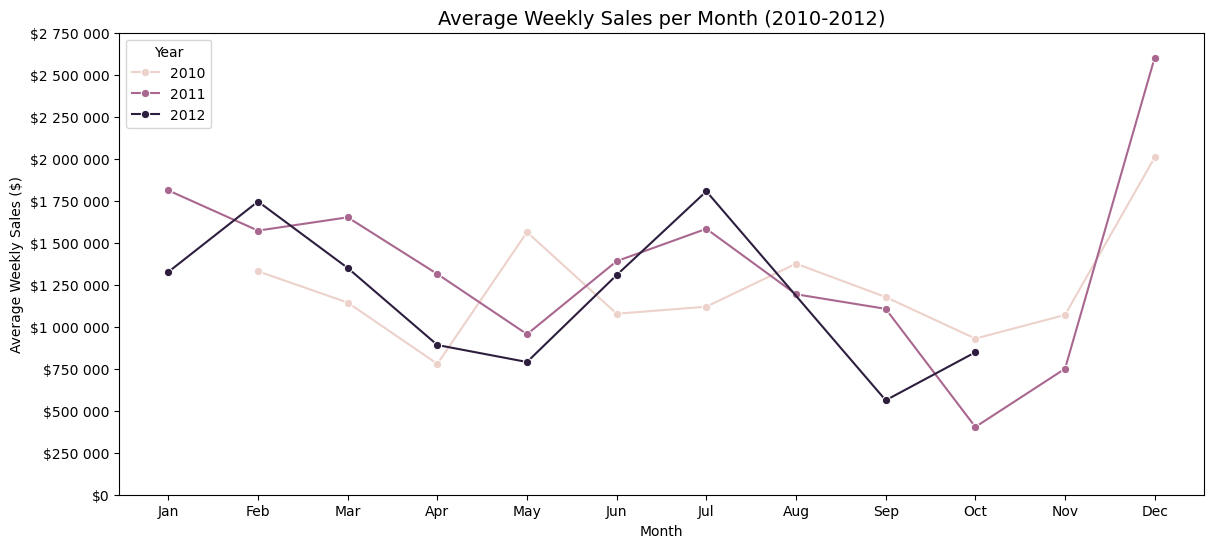

In [38]:
# Group by Year and Month
monthly_sales = df.groupby(["Year", "Month"])["Weekly_Sales"].mean().reset_index()

# Drop rows with NaN (safety)
monthly_sales = monthly_sales.dropna(subset=["Weekly_Sales"])

# Convert months to ordered categorical with abbreviations
month_order = [calendar.month_abbr[i] for i in range(1, 13)]
monthly_sales["Month"] = monthly_sales["Month"].astype(int).apply(lambda x: calendar.month_abbr[x])
monthly_sales["Month"] = pd.Categorical(monthly_sales["Month"], categories=month_order, ordered=True)

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(x="Month", y="Weekly_Sales", hue="Year", data=monthly_sales, marker="o")

plt.title("Average Weekly Sales per Month (2010-2012)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales ($)")

# Force Y-axis ticks every 250,000
ymax = int(monthly_sales["Weekly_Sales"].max())
plt.yticks(ticks=range(0, ymax + 250_000, 250_000))

# Format Y-axis with $ and spaces
formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.0f}".replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title="Year")
plt.show()


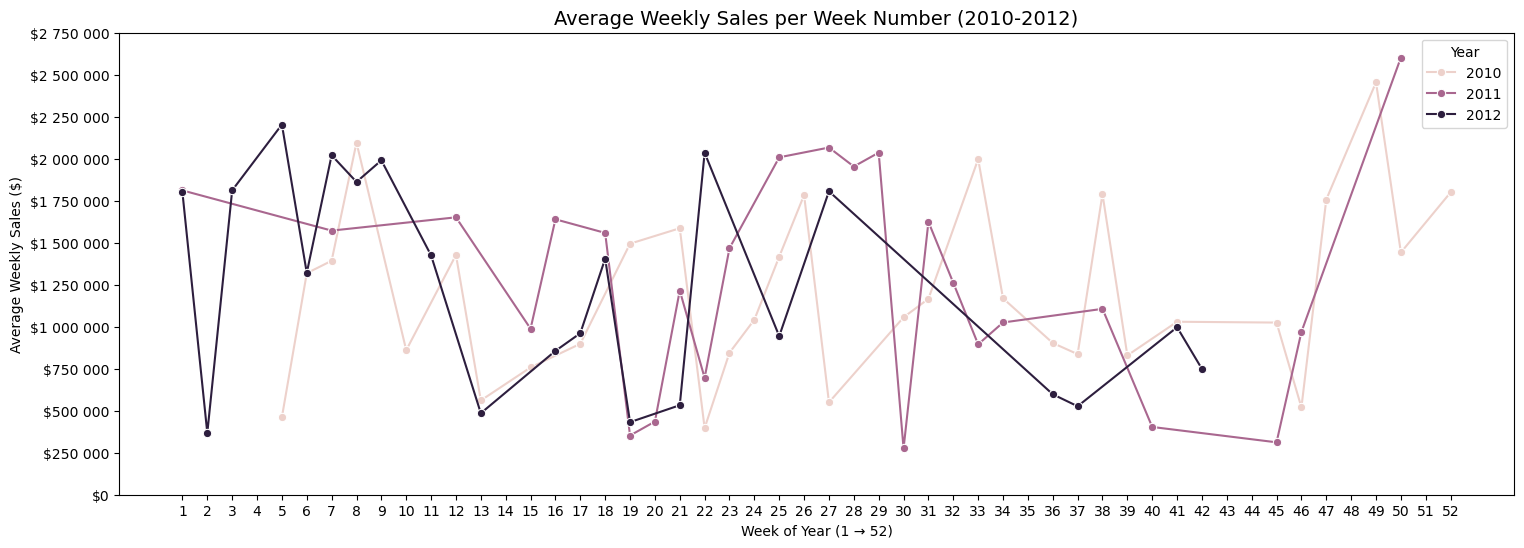

In [39]:
# Group by Year and Week
weekly_sales = df.groupby(["Year", df["Date"].dt.isocalendar().week])["Weekly_Sales"].mean().reset_index()
weekly_sales = weekly_sales.rename(columns={"week": "Week"})

# Ensure all weeks 1 → 52 are present for each Year (fill missing weeks with NaN)
all_weeks = pd.DataFrame([(year, week) for year in weekly_sales["Year"].unique() for week in range(1, 53)], 
                         columns=["Year", "Week"])
weekly_sales = pd.merge(all_weeks, weekly_sales, on=["Year", "Week"], how="left")

# Plot with points and a line
plt.figure(figsize=(18,6))
sns.lineplot(x="Week", y="Weekly_Sales", hue="Year", data=weekly_sales, marker="o")

plt.title("Average Weekly Sales per Week Number (2010-2012)", fontsize=14)
plt.xlabel("Week of Year (1 → 52)")
plt.ylabel("Average Weekly Sales ($)")

# Force X-axis to show all weeks from 1 to 52
plt.xticks(ticks=range(1, 53))

# Force Y-axis ticks every 250,000
plt.yticks(ticks=range(0, int(weekly_sales["Weekly_Sales"].max()) + 250000, 250000))

# Format Y-axis with dollar sign and spaces
formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.0f}".replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title="Year")
plt.show()

   Year  Weekly_Sales
0  2010   64377268.83
1  2011   48389509.09
2  2012   35591216.59


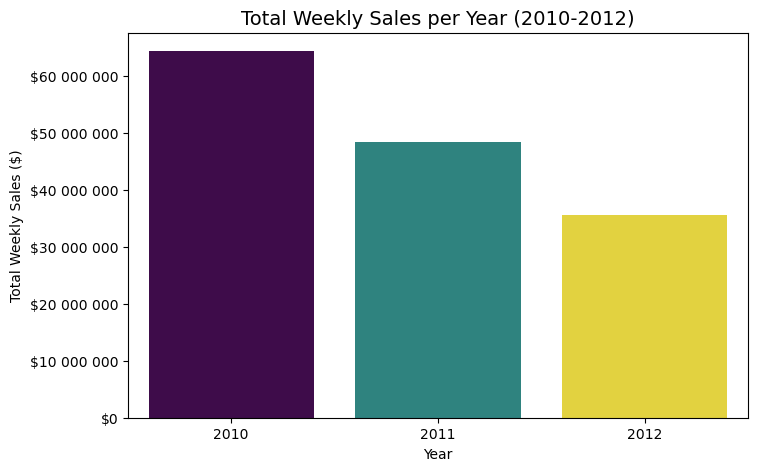

In [40]:
# Total sales per year
yearly_sales = df.groupby("Year")["Weekly_Sales"].sum().reset_index()

# Fix Year as int
yearly_sales["Year"] = yearly_sales["Year"].astype(int)

print(yearly_sales.sort_values("Weekly_Sales", ascending=False))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Year", y="Weekly_Sales", hue="Year", data=yearly_sales, palette="viridis", legend=False)

plt.title("Total Weekly Sales per Year (2010-2012)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total Weekly Sales ($)")

# Format Y-axis with $ and spaces
formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.0f}".replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()



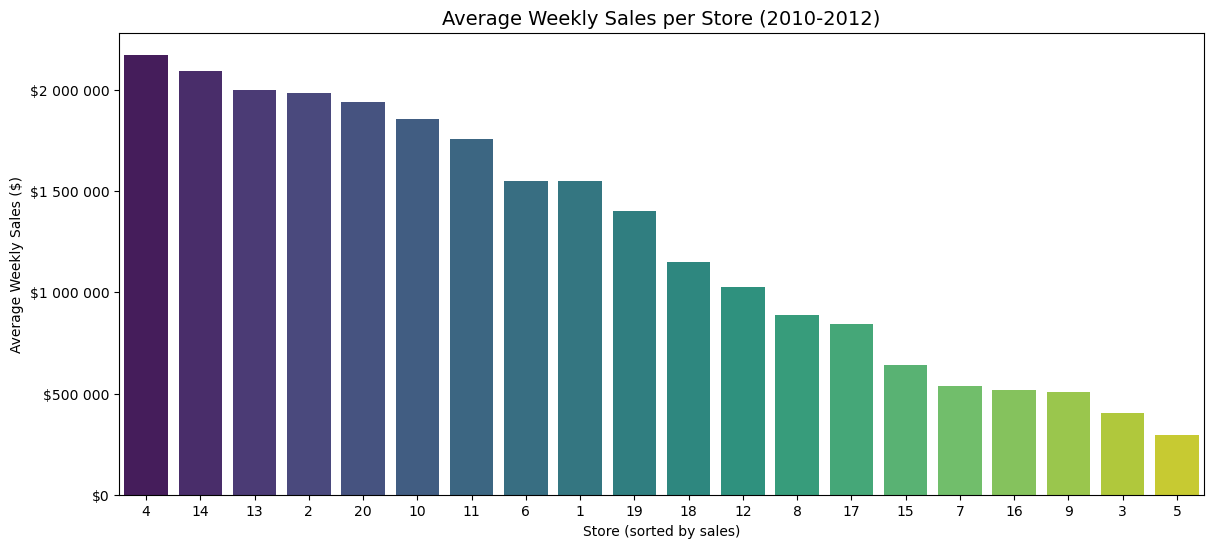

In [41]:
# Average weekly sales per store
store_sales = df.groupby("Store")["Weekly_Sales"].mean().reset_index()

# Fix Store as int
store_sales["Store"] = store_sales["Store"].astype(int)

# Sort stores by sales (descending)
store_sales = store_sales.sort_values("Weekly_Sales", ascending=False)

# Make Store a categorical ordered by sales
store_sales["Store"] = pd.Categorical(store_sales["Store"], categories=store_sales["Store"], ordered=True)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x="Store", y="Weekly_Sales", hue="Store", data=store_sales, palette="viridis", legend=False)

plt.title("Average Weekly Sales per Store (2010-2012)", fontsize=14)
plt.xlabel("Store (sorted by sales)")
plt.ylabel("Average Weekly Sales ($)")

# Format Y-axis with $ and spaces
formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.0f}".replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


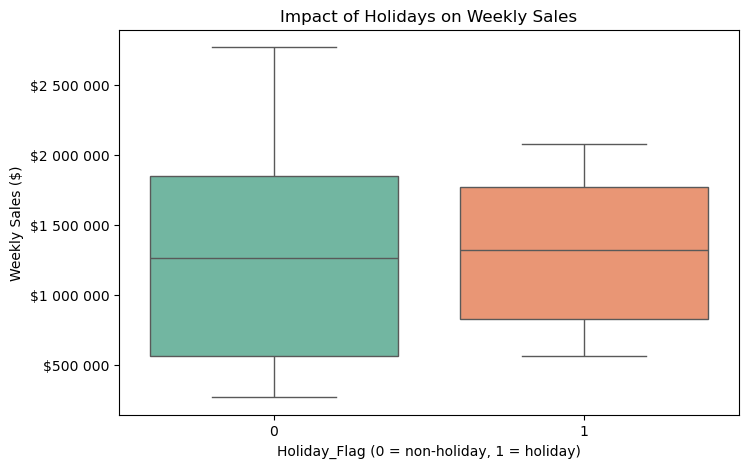

In [42]:
# Fix Holiday_Flag type
df["Holiday_Flag"] = df["Holiday_Flag"].astype("Int64")

plt.figure(figsize=(8,5))
sns.boxplot(x="Holiday_Flag", y="Weekly_Sales", hue="Holiday_Flag",
            data=df, palette="Set2", legend=False)

plt.title("Impact of Holidays on Weekly Sales")
plt.xlabel("Holiday_Flag (0 = non-holiday, 1 = holiday)")
plt.ylabel("Weekly Sales ($)")

formatter = mtick.FuncFormatter(lambda x, _: f"${x:,.0f}".replace(",", " "))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

We can see that the average weekly sales is slightly higher during the holidays, it doesn't really have an impact on the weekly sales.

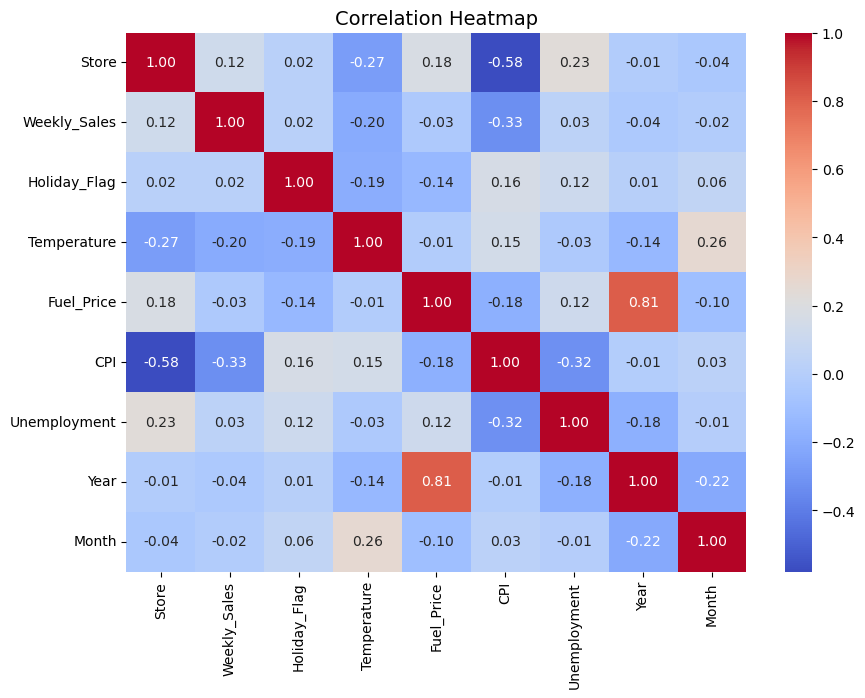

In [43]:
plt.figure(figsize=(10,7))
corr = df.corr(numeric_only=True)  # calcule les corrélations entre colonnes numériques
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap", fontsize=14)
plt.show()


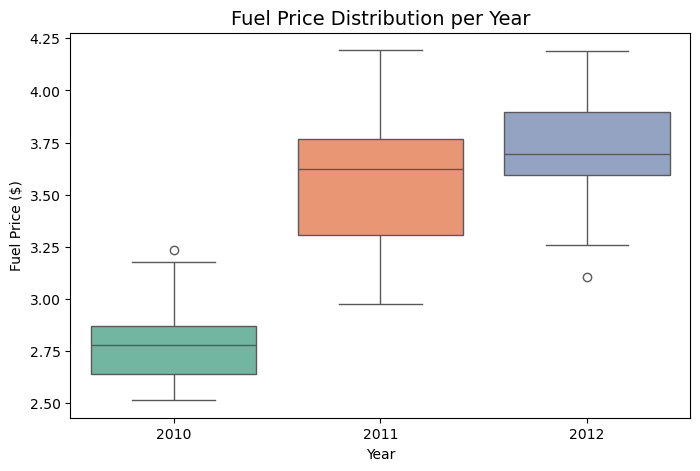

In [44]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Year", y="Fuel_Price", hue="Year",
            data=df, palette="Set2", legend=False)

plt.title("Fuel Price Distribution per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Fuel Price ($)")

plt.show()


We can confirm the corelation as the fuel price increse year by year.

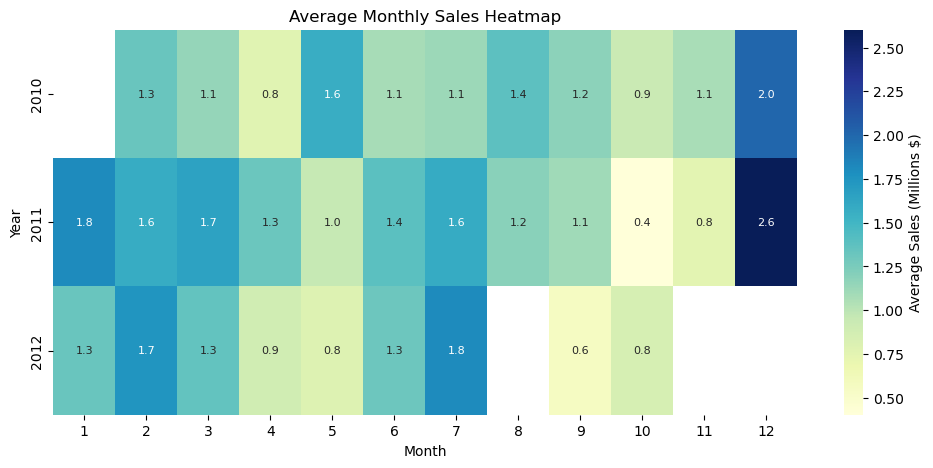

In [45]:
# Group by year and month
monthly_sales = df.groupby(["Year","Month"])["Weekly_Sales"].mean().reset_index()

# Ensure Month and Year are integers (no .0)
monthly_sales["Month"] = monthly_sales["Month"].astype(int)
monthly_sales["Year"] = monthly_sales["Year"].astype(int)

# Pivot for heatmap
pivot = monthly_sales.pivot(index="Year", columns="Month", values="Weekly_Sales")
pivot_million = pivot / 1_000_000


plt.figure(figsize=(12,5))
sns.heatmap(
    pivot_million,
    annot=True,
    fmt=".1f",           # un chiffre après la virgule
    cmap="YlGnBu",
    annot_kws={"size":8}, # taille plus petite pour rentrer dans les cases
    cbar_kws={"label":"Average Sales (Millions $)"}
)

plt.title("Average Monthly Sales Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()



# Supervised Machine Learning

In [46]:
# Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

## Preprocessing

In [47]:
# Extract ISO week (1–52)
df["Week"] = df["Date"].dt.isocalendar().week

# Drop rows where target is NaN
df = df.dropna(subset=["Weekly_Sales"])

# Drop outliers on selected numeric columns
num_cols_outliers = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

for col in num_cols_outliers:
    before = df.shape[0]
    mean = df[col].mean()
    std = df[col].std()
    lower, upper = mean - 3*std, mean + 3*std
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = df.shape[0]
    print(f"{col}: removed {before - after} rows as outliers")

print("Remaining rows after outlier removal:", df.shape[0])

Temperature: removed 11 rows as outliers
Fuel_Price: removed 11 rows as outliers
CPI: removed 5 rows as outliers
Unemployment: removed 11 rows as outliers
Remaining rows after outlier removal: 80


In [48]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define target and features
X = df[["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week"]]
y = df["Weekly_Sales"]

# Features groups
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week"]
categorical_features = ["Store", "Holiday_Flag"]

# Transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Linear Regression

In [49]:
# Define pipeline
linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Train
linreg.fit(X_train, y_train)

# Predict
y_pred = linreg.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²  :", round(r2, 4))


Linear Regression Results:
MAE : 104238.98
RMSE: 130067.14
R²  : 0.9638


MAE (Mean Absolute Error)
→ erreur moyenne absolue entre les vraies ventes et les prédictions.
→ interprétation claire : en moyenne, le modèle se trompe de X dollars par semaine.

RMSE (Root Mean Squared Error)
→ pareil que MAE mais pénalise davantage les grosses erreurs.
→ “quand ça se trompe fort, ça coûte plus cher dans ce score.”

R² (coefficient de détermination)
→ part de la variance expliquée par le modèle.
→ proche de 1 = excellent modèle.

MAE = average prediction error in original units: on average, the model’s weekly sales predictions are off by about 100k dollars per store per week.

RMSE = error with focus on big mistakes: when the model makes big mistakes, they’re usually around 130k–145k dollars off.

R² = overall explanatory power of the model: the model explains about 94–95% of the variability in weekly sales, which means it captures most of the important patterns in the data.

## Regularization: Ridge & Lasso

Ridge Regression (L2 penalty): it shrinks large coefficients but never forces them to zero. This means all features remain in the model, just with smaller weights. It’s useful when you believe that all variables carry some information and you don’t want to exclude any.

Ridge = keeps all features but tames them

Lasso Regression (L1 penalty): it shrinks some coefficients all the way to zero. This means it effectively removes irrelevant features, performing automatic feature selection. It’s useful when you think that only a subset of the variables are really important.

Lasso = keeps only the most useful ones.

In [50]:
# Ridge Regression
ridge = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=1.0, max_iter=5000, random_state=42))
])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge Regression")
print("MAE :", round(mean_absolute_error(y_test, y_pred_ridge), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 2))
print("R²  :", round(r2_score(y_test, y_pred_ridge), 4))

print("\n")

# Lasso Regression
lasso = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=0.01, max_iter=100000, random_state=42))
])
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso Regression")
print("MAE :", round(mean_absolute_error(y_test, y_pred_lasso), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), 2))
print("R²  :", round(r2_score(y_test, y_pred_lasso), 4))


Ridge Regression
MAE : 175770.21
RMSE: 239715.37
R²  : 0.8769


Lasso Regression
MAE : 104240.0
RMSE: 130070.88
R²  : 0.9638


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e+10, tolerance: 2.905e+09
  model = cd_fast.enet_coordinate_descent(


### Interpretation of the three models

Linear Regression and Lasso achieved very similar performance (R² ≈ 0.964), with low prediction errors. Ridge performed significantly worse, with higher errors and lower explanatory power. Lasso is particularly interesting since it combines strong performance with feature selection.

/var/folders/0d/cq05m_v54h79z_gtnnbhcx1w0000gn/T/ipykernel_32468/1455623256.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MAE", data=results, ax=axes[0], palette="Set2")
/var/folders/0d/cq05m_v54h79z_gtnnbhcx1w0000gn/T/ipykernel_32468/1455623256.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results, ax=axes[1], palette="Set2")
/var/folders/0d/cq05m_v54h79z_gtnnbhcx1w0000gn/T/ipykernel_32468/1455623256.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results, ax

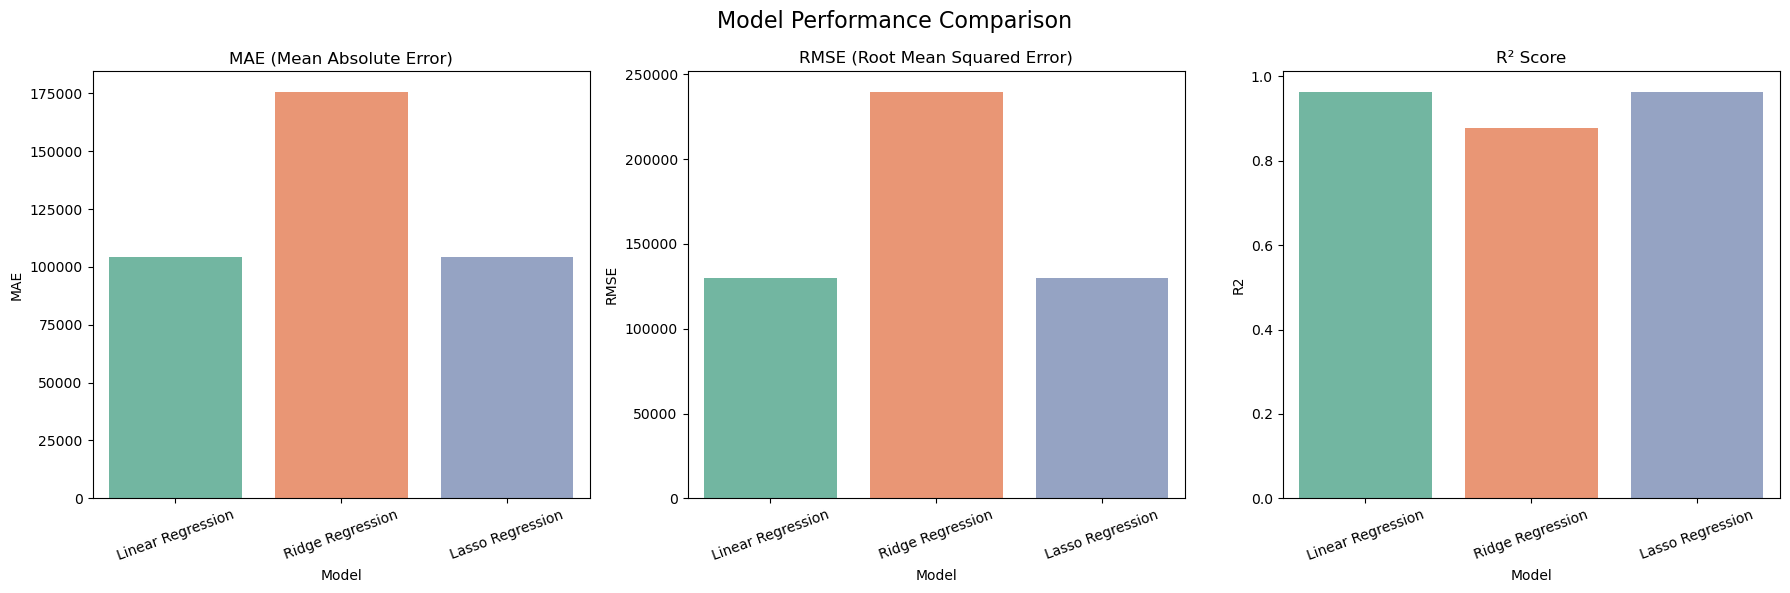

In [51]:
# Create DataFrame with results
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "MAE": [104238.98, 175770.21, 104240.0],
    "RMSE": [130067.14, 239715.37, 130070.88],
    "R2": [0.9638, 0.8769, 0.9638]
})

# Plot metrics (MAE, RMSE, R²)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x="Model", y="MAE", data=results, ax=axes[0], palette="Set2")
axes[0].set_title("MAE (Mean Absolute Error)")
axes[0].tick_params(axis='x', rotation=20)

sns.barplot(x="Model", y="RMSE", data=results, ax=axes[1], palette="Set2")
axes[1].set_title("RMSE (Root Mean Squared Error)")
axes[1].tick_params(axis='x', rotation=20)

sns.barplot(x="Model", y="R2", data=results, ax=axes[2], palette="Set2")
axes[2].set_title("R² Score")
axes[2].tick_params(axis='x', rotation=20)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout()
plt.show()


The comparison of the three models shows that Linear Regression and Lasso Regression perform almost identically, with very low errors (MAE ≈ 104k, RMSE ≈ 130k) and a high coefficient of determination (R² ≈ 0.964). This means both models explain around 96% of the variance in weekly sales.

On the other hand, Ridge Regression performs significantly worse, with higher errors (MAE ≈ 176k, RMSE ≈ 240k) and a lower R² (≈ 0.877). This suggests that Ridge penalized the coefficients too strongly, reducing the model’s ability to capture important patterns in the data.

Overall, Lasso is the most interesting model because it performs as well as Linear Regression while also performing feature selection by setting some coefficients to zero, making the model potentially more interpretable.

## GridserachCV

We tested hyperparameter tuning using GridSearchCV, but in this dataset, the optimized models did not outperform the manually selected ones. Therefore, we decided to keep the original configurations (Linear Regression and Lasso with α=0.001), which yielded better predictive performance.

In [52]:
# Define pipeline with Ridge
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(max_iter=5000, random_state=42))
])

# Define hyperparameter grid
param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}

# GridSearchCV
ridge_search = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
ridge_search.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_search.best_params_)
print("Best Ridge R²:", ridge_search.best_score_)


Best Ridge alpha: {'model__alpha': 0.01}
Best Ridge R²: 0.7953665516319566


In [53]:
# Define pipeline with Lasso
lasso_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Lasso(max_iter=50000, random_state=42))
])

# Define hyperparameter grid
param_grid = {"model__alpha": [0.0001, 0.001, 0.01, 0.1, 1]}

# GridSearchCV
lasso_search = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
lasso_search.fit(X_train, y_train)

print("Best Lasso alpha:", lasso_search.best_params_)
print("Best Lasso R²:", lasso_search.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+10, tolerance: 2.356e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+09, tolerance: 2.084e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+09, toler

Best Lasso alpha: {'model__alpha': 1}
Best Lasso R²: 0.8928361237290725


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+10, tolerance: 2.356e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.523e+09, tolerance: 2.084e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+09, toler